In [94]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import feature
import cv2
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt


In [95]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
print(os.getcwd())
os.chdir("/content/drive/MyDrive/Colab Notebooks/ASG2/RIT_18")
print(os.getcwd())


/content
/content/drive/MyDrive/Colab Notebooks/ASG2/RIT_18


# Reading Numpy Data

In [97]:
classes = np.load( 'classes.npy')
train = np.load( 'train_data.npy')
labels = np.load( 'train_labels.npy')
mask = np.load( 'train_mask.npy')

# Writing Functions For Our Model

In [98]:
# This function takes mean, variance and prior values for each target
def mean_var_prior_function(X_train, y_train):
    y_unique = np.unique(y_train)
    mean_var_prior = {}

    for i in y_unique:
        x_matched = X_train[y_train == i] # Holds a specific values that matched with label
        x_prior = x_matched.shape[0] / X_train.shape[0] # Prior probability of x_matched
        x_variance = np.var(x_matched, axis=0) # Variance of it
        x_mean = np.mean(x_matched, axis=0) # Mean of it

        mean_var_prior[i] = {"mean": x_mean, "variance": x_variance, "prior": x_prior}

    return mean_var_prior



In [99]:
# I saw this in an internet . So I really dont understand what is going on in here :/ (I think I need to check naive bayes one more time)

def naive_bayes_function(X_test,y_train,mean_var_prior, Gaussian_Coefficient):

    pred_y = {}
    probs = np.zeros((X_test.shape[0], len(np.unique(y_train))))
    for label , param in mean_var_prior.items():
        Prob_x = (((Gaussian_Coefficient *  np.sum(np.log(2 * np.pi * param["variance"][0]))) - Gaussian_Coefficient * np.sum(np.square(X_test - param["mean"][0]) / (2 * param["variance"][0]), axis=1)))


        probs[: , label] = Prob_x + np.log(param['prior'])
        pred_y = np.unique(y_train)[np.argmax(probs, axis=1)]
    return pred_y



In [100]:
def accuracy_function(X_train,X_test,y_train,y_test,Gaussian_Coefficient):
    return (naive_bayes_function(X_test,y_train,mean_var_prior_function(X_train, y_train),Gaussian_Coefficient) == y_test).sum() / len(y_test)
    # Accuracy = True values/All values


In [101]:
def accuracy_writer(x_train,x_test,y_train,y_test,coefficient):

    ALL_ACC = accuracy_function(x_train[:, :], x_test[:, :], y_train, y_test, coefficient)
    print("All Layers Accuracy Is : ", str(ALL_ACC))

    RGB_ACC = accuracy_function(x_train[:, :3], x_test[:, :3], y_train, y_test, coefficient)
    print("RGB Layers Accuracy Is : ", str(RGB_ACC))

    INF_ACC = accuracy_function(x_train[:, 3:], x_test[:, 3:], y_train, y_test, coefficient)
    print("Infrared Layers Accuracy Is : ", str(INF_ACC))

    for i in range(x_train.shape[1]):
      LAYER_ACC = accuracy_function(x_train[:, i:i+1], x_test[:, i:i+1], y_train, y_test, coefficient)
      print(str(i)+ "th layers accuracy is : " + str(LAYER_ACC))



# Showing Images

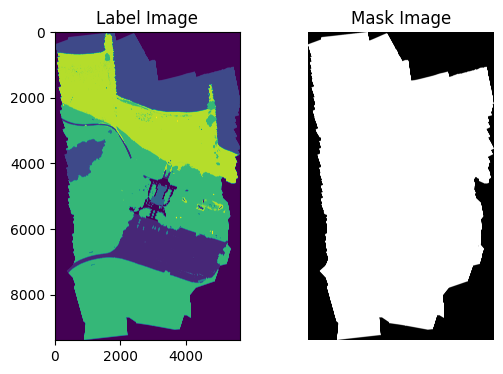

In [102]:
plt.figure(figsize=(6, 4))
label_image = Image.fromarray(labels)
mask_image = Image.fromarray(mask)

plt.subplot(1, 2, 1)
plt.imshow(label_image)
plt.title("Label Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_image, cmap ="gray") # Convert to black&white because of Human Perception
plt.title("Mask Image")

plt.axis("off")
plt.show()

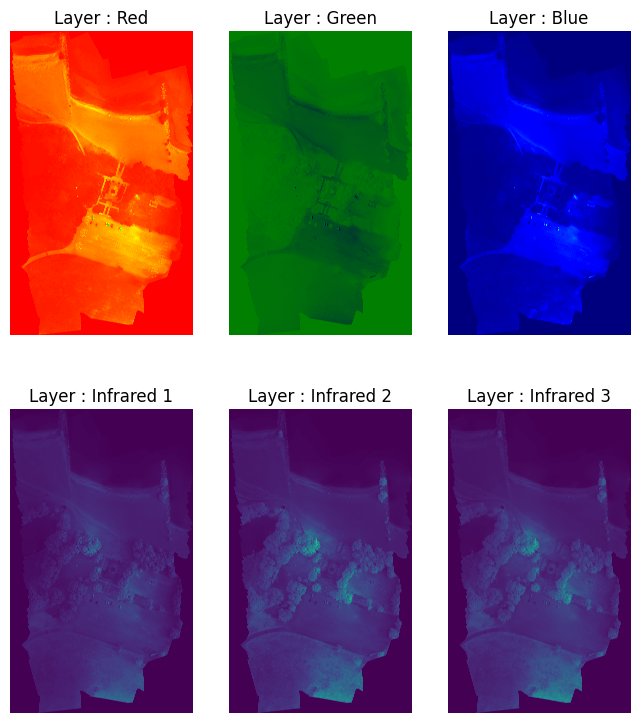

In [103]:
# Splitting train image into layers
layers = np.split(train, train.shape[-1], axis=-1)

subplots = plt.subplots(2, 3, figsize=(8,9))
figure, axes = subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

layer_names = ["Red","Green","Blue","Infrared 1","Infrared 2","Infrared 3"]

filters = ["hsv","ocean","jet","viridis","viridis","viridis"]
# I used 'viridis' for Inferno Channels because GPT suggest me to do this :D
# And used hsv for red, ocean for green and jet for blue. (It was experimental xD )
j=0
for i  in layers:
    axes[j].imshow(i,cmap = filters[j]) # All images was purple in a way I cannot understand. So I use cmap filtering to images to see layers better
    axes[j].set_title("Layer : " + layer_names[j])
    axes[j].axis('off')
    j+=1


plt.show()


# Masking

In [104]:
# Masking train data and label data
# This will be used for visualizations of layers
train_masked = np.where(mask[:, :, np.newaxis] == 0, np.nan, train) # np.newaxis because train shape was(9393,5642,6) and mask was (9393,5642)
label_masked = np.where(mask[:, :] == 0, np.nan, labels) # np.newaxis is not here because they have same sizes

# Will be used for calculations later
train_cal = train[mask != 0]
label_cal = labels[mask != 0]


# I seperate data for calculation and visualization because they don't do the same job in a way I don't understand

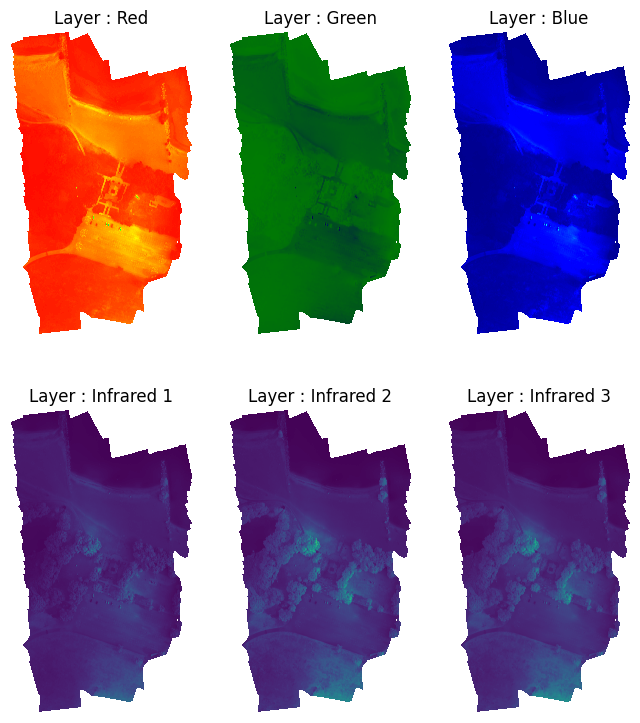

In [105]:
# Do same job but with masked train data
layers = np.split(train_masked, train_masked.shape[-1], axis=-1)
subplots = plt.subplots(2, 3, figsize=(8,9))
figure, axes = subplots
axes = axes.flatten()

layers_splitted = list()

j=0
for i  in layers:
    layers_splitted.append(i)
    axes[j].imshow(i,cmap = filters[j])
    axes[j].set_title("Layer : " + layer_names[j])
    axes[j].axis('off')
    j+=1


plt.show()


# Splitting Data To 0.8 percent to 0.2 Percent

In [106]:
# Random state = 0 because we want to take first 80 percent as train data
x_train, x_test, y_train, y_test =  train_test_split(train_cal, label_cal, test_size=0.2, random_state=0)


In [107]:
# It is the normal Gaussian Function for our image but I want to try it with different coefficient to see if I can get better result or not
coefficient = 0.5
accuracy_writer(x_train,x_test,y_train,y_test,coefficient)


All Layers Accuracy Is :  0.29418917454328536
RGB Layers Accuracy Is :  0.5976121474875108
Infrared Layers Accuracy Is :  0.44740003924830063
0th layers accuracy is : 0.6522766720713851
1th layers accuracy is : 0.5222333818755174
2th layers accuracy is : 0.6039663944922474
3th layers accuracy is : 0.4675538779851146
4th layers accuracy is : 0.4678933669742543
5th layers accuracy is : 0.4678939963568816


### First at all I know that I shouldn't change coefficient and also there is no variable like coefficient in the gaussian calculation. It is just a square of a number but I just wonder that if we can find better solution or not and try something like that

In [ ]:
coef_list = [round(x, 1) for x in np.arange(0, 2.1, 0.1)]

for coefficient in coef_list:
  print("Coef is : ", coefficient)

  try:
    accuracy_writer(x_train,x_test,y_train,y_test,coefficient)
  except:
    print("There is an error occured in this coef")


Coef is :  0.0
All Layers Accuracy Is :  0.4678939963568816
RGB Layers Accuracy Is :  0.4678939963568816
Infrared Layers Accuracy Is :  0.4678939963568816
0th layers accuracy is : 0.4678939963568816
1th layers accuracy is : 0.4678939963568816
2th layers accuracy is : 0.4678939963568816
3th layers accuracy is : 0.4678939963568816
4th layers accuracy is : 0.4678939963568816
5th layers accuracy is : 0.4678939963568816
Coef is :  0.1
All Layers Accuracy Is :  0.35809807115623754
RGB Layers Accuracy Is :  0.5963873688948784
Infrared Layers Accuracy Is :  0.46769712547107717
0th layers accuracy is : 0.5018608956139962
1th layers accuracy is : 0.46811415439989434
2th layers accuracy is : 0.4717635666257526
3th layers accuracy is : 0.4678939963568816
4th layers accuracy is : 0.4678939963568816
5th layers accuracy is : 0.4678939963568816
Coef is :  0.2
All Layers Accuracy Is :  0.35621609122422854
RGB Layers Accuracy Is :  0.6166286918168804
Infrared Layers Accuracy Is :  0.4653189402757426
0th

### As we can see in the results 0.4 has the highest accuracy.
### Let start with a random line and see if our model is overfitting or not

In [ ]:
import random
for i in range(5):

  random_integer = random.randint(1, 39721460)
  coefficient = 0.4
  x_train, x_test, y_train, y_test =  train_test_split(train_cal, label_cal, test_size=0.2, random_state=random_integer)
  print(str(i),"TH ITERATION, ACCURACIES ARE : ",end = "\n")

  accuracy_writer(x_train,x_test,y_train,y_test,coefficient)
  print("\n\n\n")

0 TH ITERATION, ACCURACIES ARE : 
All Layers Accuracy Is :  0.3419838618741781
RGB Layers Accuracy Is :  0.6114936848376564
Infrared Layers Accuracy Is :  0.45968332235480236
0th layers accuracy is : 0.6335107479041873
1th layers accuracy is : 0.4906368634691596
2th layers accuracy is : 0.5483083264929931
3th layers accuracy is : 0.46802377505462095
4th layers accuracy is : 0.46803195702877526
5th layers accuracy is : 0.46803195702877526




1 TH ITERATION, ACCURACIES ARE : 
All Layers Accuracy Is :  0.34203849228622357
RGB Layers Accuracy Is :  0.6116223306466667
Infrared Layers Accuracy Is :  0.45983525532102104
0th layers accuracy is : 0.6337307800706746
1th layers accuracy is : 0.4909053580979453
2th layers accuracy is : 0.5485929333170365
3th layers accuracy is : 0.4681726869842288
4th layers accuracy is : 0.46818300885931574
5th layers accuracy is : 0.46818300885931574




2 TH ITERATION, ACCURACIES ARE : 
All Layers Accuracy Is :  0.342301322471364
RGB Layers Accuracy Is :  0.61

## As we can see our model is not overfitting or underfitting. So we did our job well!!!

# Result & Discussion
All: All layer always has the fewest accuracy. So we can say our model is not working well in the all layers

RGB: Considering only the RGB layers, indicating that these color channels are contributing significantly to the model's performance.

Infrared Chanells: The accuracy is 0.460 when considering only the Infrared layers. This suggests that the model gains some information from the Infrared channels but not as much as from RGB.

Individual Layers: The Red layer (0th) has the highest accuracy with 0.634, while the 4th and 5th layers have accuracies of 0.468. This information indicates the importance of each specific layer in isolation.

Finally we can say,  RGB information is more informative for our model compared to Infrared channels and individual layer accuracies suggests varying degrees of importance for each channel, with the Red channel being the most influential.

In addition to the study, I attempted to achieve the highest accuracy for our model by trying different values in the Gaussian process, for which I normally take the square root using a coefficient of 0.5. I experimented with different values to see if the model overfits or underfits, testing it in various sections.



## Lets inspect the change of accuracies with the coefficient in the graph

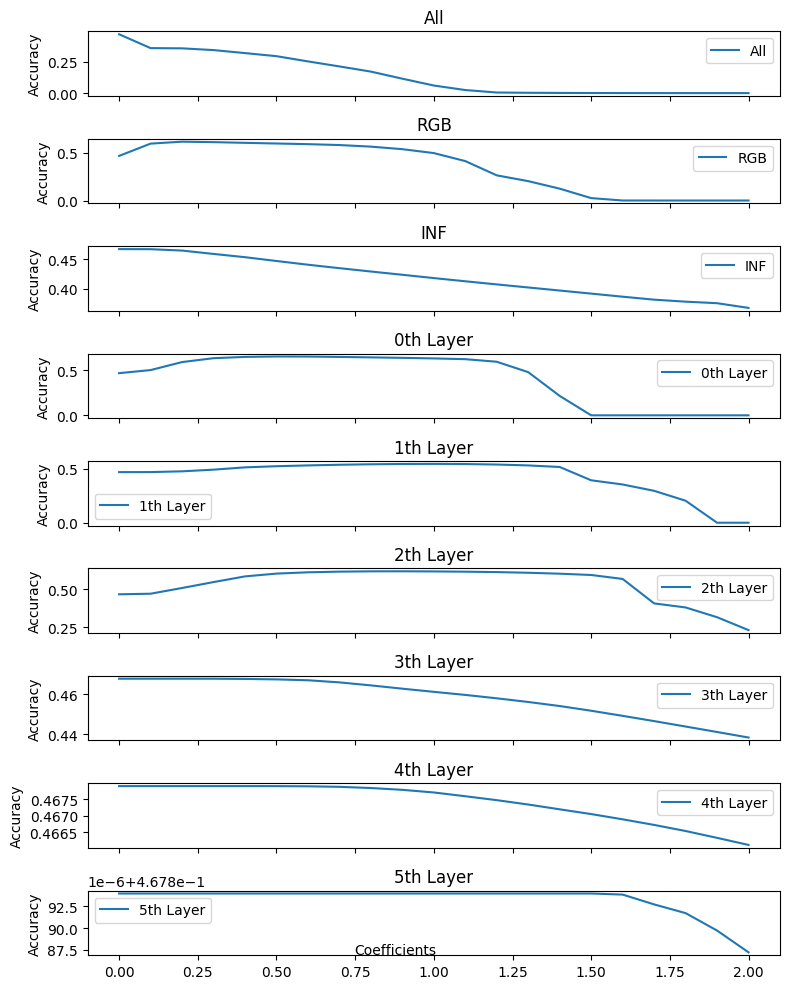

In [ ]:
x = """

Coef is :  0.0
All Layers Accuracy Is :  0.4678939963568816
RGB Layers Accuracy Is :  0.4678939963568816
Infrared Layers Accuracy Is :  0.4678939963568816
0th layers accuracy is : 0.4678939963568816
1th layers accuracy is : 0.4678939963568816
2th layers accuracy is : 0.4678939963568816
3th layers accuracy is : 0.4678939963568816
4th layers accuracy is : 0.4678939963568816
5th layers accuracy is : 0.4678939963568816
Coef is :  0.1
All Layers Accuracy Is :  0.35809807115623754
RGB Layers Accuracy Is :  0.5963873688948784
Infrared Layers Accuracy Is :  0.46769712547107717
0th layers accuracy is : 0.5018608956139962
1th layers accuracy is : 0.46811415439989434
2th layers accuracy is : 0.4717635666257526
3th layers accuracy is : 0.4678939963568816
4th layers accuracy is : 0.4678939963568816
5th layers accuracy is : 0.4678939963568816
Coef is :  0.2
All Layers Accuracy Is :  0.35621609122422854
RGB Layers Accuracy Is :  0.6166286918168804
Infrared Layers Accuracy Is :  0.4653189402757426
0th layers accuracy is : 0.5905639431979661
1th layers accuracy is : 0.47512610625010937
2th layers accuracy is : 0.5093093872544732
3th layers accuracy is : 0.46789714327001786
4th layers accuracy is : 0.4678939963568816
5th layers accuracy is : 0.4678939963568816
Coef is :  0.3
All Layers Accuracy Is :  0.34246194091783877
RGB Layers Accuracy Is :  0.6117951591161102
Infrared Layers Accuracy Is :  0.4595500191143504
0th layers accuracy is : 0.6335399512580918
1th layers accuracy is : 0.4905321341999848
2th layers accuracy is : 0.5482412343049281
3th layers accuracy is : 0.46788455561747283
4th layers accuracy is : 0.4678939963568816
5th layers accuracy is : 0.4678939963568816
Coef is :  0.4
All Layers Accuracy Is :  0.318557359352179
RGB Layers Accuracy Is :  0.6044519002509097
Infrared Layers Accuracy Is :  0.4539419681524838
0th layers accuracy is : 0.6476766403253253
1th layers accuracy is : 0.5116616418855648
2th layers accuracy is : 0.5856156111059851
3th layers accuracy is : 0.4677726513863474
4th layers accuracy is : 0.4678939963568816
5th layers accuracy is : 0.4678939963568816
Coef is :  0.5
All Layers Accuracy Is :  0.29418917454328536
RGB Layers Accuracy Is :  0.5976121474875108
Infrared Layers Accuracy Is :  0.44740003924830063
0th layers accuracy is : 0.6522766720713851
1th layers accuracy is : 0.5222333818755174
2th layers accuracy is : 0.6039663944922474
3th layers accuracy is : 0.4675538779851146
4th layers accuracy is : 0.4678933669742543
5th layers accuracy is : 0.4678939963568816
Coef is :  0.6
All Layers Accuracy Is :  0.2526203401611698
RGB Layers Accuracy Is :  0.5907074424369796
Infrared Layers Accuracy Is :  0.440990154819315
0th layers accuracy is : 0.651465901370959
1th layers accuracy is : 0.52965267016209
2th layers accuracy is : 0.6125243618280444
3th layers accuracy is : 0.4671111702451055
4th layers accuracy is : 0.4678877025306091
5th layers accuracy is : 0.4678939963568816
Coef is :  0.7
All Layers Accuracy Is :  0.21282258849214147
RGB Layers Accuracy Is :  0.5813691665199157
Infrared Layers Accuracy Is :  0.4350651467663642
0th layers accuracy is : 0.6473762989356007
1th layers accuracy is : 0.5356874425452334
2th layers accuracy is : 0.6168590458584546
3th layers accuracy is : 0.46604877237030407
4th layers accuracy is : 0.4678719679649278
5th layers accuracy is : 0.4678939963568816
Coef is :  0.8
All Layers Accuracy Is :  0.17174077038699354
RGB Layers Accuracy Is :  0.5648080955725072
Infrared Layers Accuracy Is :  0.4293042817026008
0th layers accuracy is : 0.642437281706503
1th layers accuracy is : 0.5401746889244896
2th layers accuracy is : 0.6188940916454113
3th layers accuracy is : 0.46454668779210434
4th layers accuracy is : 0.46783584140212353
5th layers accuracy is : 0.4678939963568816
Coef is :  0.9
All Layers Accuracy Is :  0.11551336286312702
RGB Layers Accuracy Is :  0.5382248615452627
Infrared Layers Accuracy Is :  0.4236928320745471
0th layers accuracy is : 0.6371255440855467
1th layers accuracy is : 0.5428364739316639
2th layers accuracy is : 0.6191423201535996
3th layers accuracy is : 0.4628959430373477
4th layers accuracy is : 0.4677808333605017
5th layers accuracy is : 0.4678939963568816
Coef is :  1.0
All Layers Accuracy Is :  0.06131130863375759
RGB Layers Accuracy Is :  0.4972737032735323
Infrared Layers Accuracy Is :  0.4180015767293578
0th layers accuracy is : 0.6308518580570983
1th layers accuracy is : 0.5437184907454949
2th layers accuracy is : 0.6182906395824022
3th layers accuracy is : 0.46130889180446893
4th layers accuracy is : 0.46770140527294246
5th layers accuracy is : 0.4678939963568816
Coef is :  1.1
All Layers Accuracy Is :  0.025402638095045085
RGB Layers Accuracy Is :  0.4134735463558557
Infrared Layers Accuracy Is :  0.4124932199756479
0th layers accuracy is : 0.6224570266982852
1th layers accuracy is : 0.5422774562821386
2th layers accuracy is : 0.6165642430358498
3th layers accuracy is : 0.45977357582355033
4th layers accuracy is : 0.46758723526435897
5th layers accuracy is : 0.4678939963568816
Coef is :  1.2
All Layers Accuracy Is :  0.005829090140557504
RGB Layers Accuracy Is :  0.26423169437481725
Infrared Layers Accuracy Is :  0.4071138866605247
0th layers accuracy is : 0.5940018828610677
1th layers accuracy is : 0.5377631464499106
2th layers accuracy is : 0.613814596213911
3th layers accuracy is : 0.4580747462360716
4th layers accuracy is : 0.46746840782433374
5th layers accuracy is : 0.4678939963568816
Coef is :  1.3
All Layers Accuracy Is :  0.003692461997562275
RGB Layers Accuracy Is :  0.20372675076309496
Infrared Layers Accuracy Is :  0.40184922686008684
0th layers accuracy is : 0.4789384026999004
1th layers accuracy is : 0.5294745548785776
2th layers accuracy is : 0.6094664433952776
3th layers accuracy is : 0.45623342442178305
4th layers accuracy is : 0.46733648922566173
5th layers accuracy is : 0.4678939963568816
Coef is :  1.4
All Layers Accuracy Is :  0.0024830403410347527
RGB Layers Accuracy Is :  0.12505581050447157
Infrared Layers Accuracy Is :  0.3965817977760891
0th layers accuracy is : 0.21567117426308421
1th layers accuracy is : 0.5151221134467221
2th layers accuracy is : 0.6033438091973697
3th layers accuracy is : 0.45420089616533527
4th layers accuracy is : 0.4671913535918174
5th layers accuracy is : 0.4678939963568816
Coef is :  1.5
All Layers Accuracy Is :  0.0018001601904662882
RGB Layers Accuracy Is :  0.026306431547779015
Infrared Layers Accuracy Is :  0.3912966201020028
0th layers accuracy is : 0.0010983985610802623
1th layers accuracy is : 0.39240571816774633
2th layers accuracy is : 0.5948541928148924
3th layers accuracy is : 0.45184486523848
4th layers accuracy is : 0.4670479802293294
5th layers accuracy is : 0.4678939963568816
Coef is :  1.6
All Layers Accuracy Is :  0.0014392721919999677
RGB Layers Accuracy Is :  0.0012227645682252656
Infrared Layers Accuracy Is :  0.3859790921608757
0th layers accuracy is : 0.0010983985610802623
1th layers accuracy is : 0.35376124722489466
2th layers accuracy is : 0.5688552776187887
3th layers accuracy is : 0.44928793537700584
4th layers accuracy is : 0.46688899817768553
5th layers accuracy is : 0.46789387048035613
Coef is :  1.7
All Layers Accuracy Is :  0.001232708813735848
RGB Layers Accuracy Is :  0.0010983985610802623
Infrared Layers Accuracy Is :  0.3808793306087779
0th layers accuracy is : 0.0010983985610802623
1th layers accuracy is : 0.2953200492479318
2th layers accuracy is : 0.4080447435662305
3th layers accuracy is : 0.4466538432054306
4th layers accuracy is : 0.4667198201274802
5th layers accuracy is : 0.4678927375916271
Coef is :  1.8
All Layers Accuracy Is :  0.001135909765664484
RGB Layers Accuracy Is :  0.0010983985610802623
Infrared Layers Accuracy Is :  0.37743912516821826
0th layers accuracy is : 0.0010983985610802623
1th layers accuracy is : 0.20400267210688225
2th layers accuracy is : 0.38143608248084504
3th layers accuracy is : 0.4439366725270581
4th layers accuracy is : 0.4665355368942208
5th layers accuracy is : 0.4678917305794235
Coef is :  1.9
All Layers Accuracy Is :  0.0011002867089620184
RGB Layers Accuracy Is :  0.0010983985610802623
Infrared Layers Accuracy Is :  0.3748032707252867
0th layers accuracy is : 0.0010983985610802623
1th layers accuracy is : 0.0010983985610802623
2th layers accuracy is : 0.31729167088877513
3th layers accuracy is : 0.4411988580985117
4th layers accuracy is : 0.4663283441333294
5th layers accuracy is : 0.46788971655501627
Coef is :  2.0
All Layers Accuracy Is :  0.0010982726845548119
RGB Layers Accuracy Is :  0.0010983985610802623
Infrared Layers Accuracy Is :  0.36668448658678626
0th layers accuracy is : 0.0010983985610802623
1th layers accuracy is : 0.0010983985610802623
2th layers accuracy is : 0.2323827935349313
3th layers accuracy is : 0.43842630174894104
4th layers accuracy is : 0.46611422816353826
5th layers accuracy is : 0.46788719902450726
"""
x = x.split("\n")



acc_all, acc_rgb, acc_inf, acc0, acc1, acc2, acc3, acc4, acc5 = ([] for _ in range(9))

for i in x :
  if i.startswith("All"):
    i = (i.split(":"))[1]
    acc_all.append(float(i))


  if i.startswith("RGB"):
    i = (i.split(":"))[1]
    acc_rgb.append(float(i))

  if i.startswith("Inf"):
    i = (i.split(":"))[1]
    acc_inf.append(float(i))

  if i.startswith("0"):
    i = (i.split(":"))[1]
    acc0.append(float(i))

  if i.startswith("1"):
    i = (i.split(":"))[1]
    acc1.append(float(i))

  if i.startswith("2"):
    i = (i.split(":"))[1]
    acc2.append(float(i))

  if i.startswith("3"):
    i = (i.split(":"))[1]
    acc3.append(float(i))

  if i.startswith("4"):
    i = (i.split(":"))[1]
    acc4.append(float(i))

  if i.startswith("5"):
    i = (i.split(":"))[1]
    acc5.append(float(i))


# Sample data
x_values = np.arange(0, 2.1, 0.1)
titles = ["All", "RGB", "INF", "0th Layer", "1th Layer", "2th Layer", "3th Layer", "4th Layer", "5th Layer"]
y_values = [acc_all, acc_rgb, acc_inf, acc0, acc1, acc2, acc3, acc4, acc5]

# Number of subplots
num_subplots = len(titles)

# Create subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(8, 10), sharex=True)

# Plot each line in a different subplot
for i in range(num_subplots):
    axs[i].plot(x_values, y_values[i], label=titles[i])
    axs[i].set_title(titles[i])
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()

# Set common X-axis label
fig.text(0.5, 0.04, 'Coefficients', ha='center')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
lst = [0]*len(y_values[0])

for i in y_values:
  for j in range(len(i)):

    lst[j] += i[j]
max_index = lst.index(max(lst))
print(max_index , x_values[max_index])


4 0.4


As we can see from the graph the best coefficient isn't 0.5, it is
0.4 for our data and All, INF and RGB accuracy is directly decending while coefficient is increasing but layers are more tight to this change. Also we can state that first two layer is so tight to change



# Summary Of The Study
 Firstly, to train and test the model more quickly, we reduced the data by applying a mask. Subsequently, we conducted a more detailed examination by observing each layer individually. Then, we attempted to reach the maximum accuracy value by using different factors on the Gaussian function. Finally, we conducted separate tests for each layer, all layers together, RGB, and Infrared. We obtained accuracy values and observed that RGB and the 0th, 4th, and 5th layers have the most significant impact on our model.